# **ЗАДАНИЕ 8. ПОСТРОЕНИЕ МОДЕЛИ ARIMA**
Постройте модель ARIMA для временного ряда цен на материал 3. Рассчитайте показатели точности и адекватности построенной модели. Дайте точечный и интервальный прогнозы на 1 год вперёд по построенной модели.
Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.

In [ ]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.4 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 9.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import scipy.stats
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import warnings

**3. Прочитайте данные по ценам на материал 3 и приведите их к виду, пригодному для дальнейшего анализа (см. пп.1-10 Задания 1).**
**2. Убедитесь в том, что Вы работаете с объектом Series, а не DataFrame. Превратить таблицу с одним столбцом целевых значений в объект Series можно с помощью функции squeeze(). Дайте ему название series.**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/PDA-210')

In [ ]:
data=pd.read_excel('data.xls', sheet_name='Material 3')
data.head()

In [ ]:
dates =data.loc[data.index==0].values[0,2:]
val =data.loc[data.index==1].values[0,2:]

In [ ]:
data={'Date':dates,'Value':val}

In [ ]:
df=pd.DataFrame(data)
df.head()

,Date,Value
0,2007-01-01,10.07
1,2007-02-01,10.04
2,2007-03-01,10.05
3,2007-04-01,10.05
4,2007-05-01,10.03


In [ ]:
df=df.set_index('Date')
df.head()

In [ ]:
df.shape

(48, 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Value   48 non-null     object
dtypes: object(1)
memory usage: 768.0+ bytes


In [ ]:
df.Value = df.Value.astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [ ]:
series=df.squeeze()
type(series)

pandas.core.series.Series

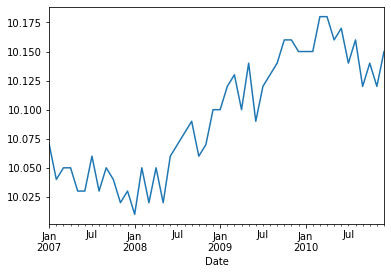

In [ ]:
series.plot()
plt.show()
# сезонности здесь нет, т.к. нет ежегодных колетаний, но тренд есть, ряд не стационарен

**4. Проверьте свою гипотезу с помощью расширенного теста Дики-Фуллера, воспользовавшись функцией adfuller() из модуля statsmodels.tsa.stattools. Прокомментируйте результат.**

In [ ]:
adfuller(series)
# p-value - это второе число (0.83369), H0(нулевая гипотеза) - рядне не стационарен
# p-value > 0.05, поэтому Н0 мы не отвергаем, т.е. ряд не стационарен

(-0.7488118918662352,
 0.833697945875383,
 1,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 -186.0406304537649)

0.83>0.05, поэтому H0 не отвергаем - ряд нестационарный.

**5. Проведите декомпозицию временного ряда на основе аддитивной модели, воспользовавшись функцией seasonal_decompose() из модуля statsmodels.tsa.seasonal. Результат представьте графически с помощью функций plot() и show() из модуля matplotlib.pyplot.**

In [ ]:
result=seasonal_decompose(series, model='additive', period=1)

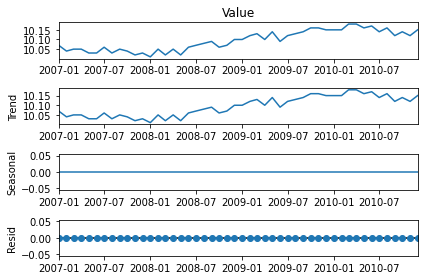

In [ ]:
result.plot() # 1.Исходный ряд, 2.Тренд, 3. Сезонность, 4. Ошибка
plt.show()

**6. Избавьтесь от тренда во временном ряду путем дифференцирования, в ходе которого строится новый ряд, в котором значение на текущем временном шаге рассчитывается, как разность между исходным наблюдением и наблюдением на предыдущем временном шаге: value(t) = observation(t) - observation(t - 1). Для этого возьмите значения временного ряда, обратившись к параметру values. Создайте список diff, в который поместите разность между исходным наблюдением и наблюдением на предыдущем временном шаге. Результат представьте графически с помощью функций plot() и show() из модуля matplotlib.pyplot. Прокомментируйте полученный результат.**

In [ ]:
X=series.values

In [ ]:
diff =list()

In [ ]:
for i in range(1,len(X)):
  value=X[i]-X[i-1]
  diff.append(value)

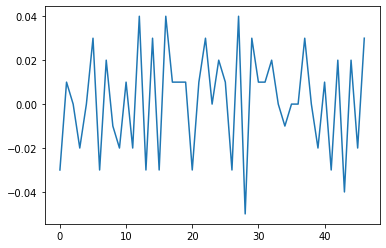

In [ ]:
plt.plot(diff) # ряд уже похож на стационарный, т.е. колебания вдоль горизогтальной оси, тренд ушел
plt.show()     # проверим гипотезу о стационарнрсти ряда!!!

**7. Проверьте полученный ряд diff на стационарность с помощью расширенного теста Дики-Фуллера, воспользовавшись функцией adfuller() из модуля statsmodels.tsa.stattools. Прокомментируйте результат.**

In [ ]:
adfuller(diff) # значение p-value оченнь мало, поэтому Н0 о том что ряд не стационарен - отвергаем

(-13.364738195818124,
 5.34106984458732e-25,
 0,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 -179.75567388655162)

# **Ряд diff стационарный, d=1.**

**8. Если ряд не стационарный найдите вторую разность, путем дифференцирования ряда diff так же, как это описано в п. 6. Проверьте полученный ряд diff2 на стационарность так же, как это описано в п. 7. Если надо, повторите эти шаги. Остановитесь, когда ряд окажется стационарным. Сделайте предположение о d - порядке разности (дискретной производной) в модели ARIMA.**

In [ ]:
# т.е. проделываем тоже самое с теми же числами второй раз и трнтий раз, пока модель не станет стационарной

**9. На основе стационарного ряда постройте коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting и функцией show() из модуля matplotlib.pyplot. Сделайте предположение о p - порядке авторегрессионной составляющей в модели ARIMA.**

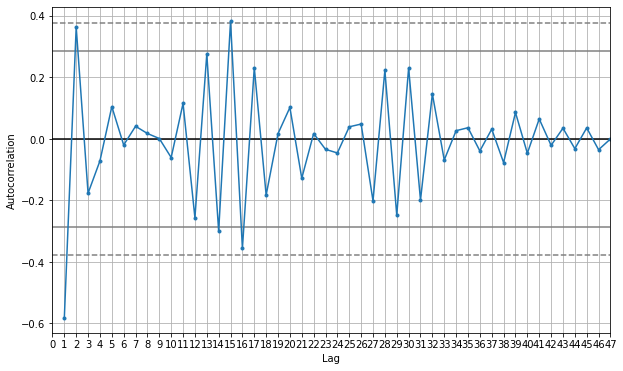

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

autocorrelation_plot(diff, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlim(0, len(diff))

plt.show()
# сплошная линия -  это уровень значимости одна сотая (0.01)
#пунктирная линия -  это уровень значимости пять сотых (0.05)
# присутствует автокорреляция при  тау = 1
# чаще всего берут уровень значимости 0.05

**10. На основе стационарного ряда постройте коррелограмму, воспользовавшись функцией plot_acf() из модуля statsmodels.graphics.tsaplots и функцией show() из модуля matplotlib.pyplot. Убедитесь в том, что получен такой же результат, что и в п.9.**

In [ ]:
# количество лагов взяли 12 (произвольно)

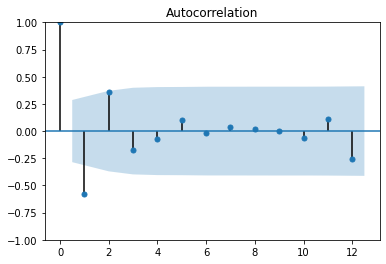

In [ ]:
plot_acf(diff, lags=12)
plt.show()
# автокорреляция наблюдается на шаге 1 и на грани на  шаге 2, поэтому
# наша гипотеза p = 1 и 2

**11. На основе стационарного ряда постройте частную автокорреляционную функцию, воспользовавшись функцией plot_pacf() из модуля statsmodels.graphics.tsaplots и функцией show() из модуля matplotlib.pyplot. Сделайте предположение о p - порядке авторегрессионной составляющей в модели ARIMA.**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


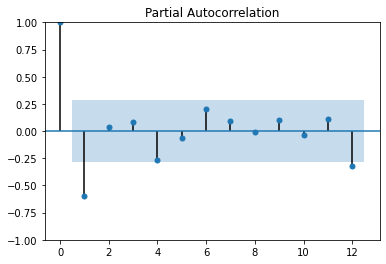

In [ ]:
plot_pacf(diff, lags=12)
plt.show()

# **Рассмотреть p=1**

**12. Рассчитайте максимальную величину лага (max_tau), как 4-ую часть объема выборки. Выведите результат на экран.**

In [ ]:
max_tau=int(len(diff)/4)
max_tau
# выходит от одного пикового значения до другого 11 зарубок

11

**13. Воспользуйтесь функцией ar_select_order() из модуля statsmodels.tsa.ar_model, чтобы определить оптимальный по критерию BIC порядок авторегрессии для стационарного ряда. Выведите результат на экран.**

In [ ]:
modelp=ar_select_order(diff, maxlag=max_tau,old_names=False)

In [ ]:
modelp.ar_lags
# здесь тоже 1, значит p надо брать p = 1

[1]

# **это d наверно**

**14. По стационарному ряду постройте модель авторегрессии, порядок которой определен в п. 13. Способы построения авторегрессия смотрите в задании 7. Предпочтительно воспользоваться функцией AutoReg из модуля statsmodels.tsa.ar_model. Выведите на экран коэффициенты модели, расчетные и фактические значения для тестового набора, показатель качества RMSE и диаграмму с фактическими и расчетными значениями для тестовой выборки. Что Вы можете сказать о качестве построенной модели?**

In [ ]:
X=diff

In [ ]:
train, test = X[0:len(X)-12], X[len(X)-12:]

In [ ]:
model=AutoReg(train, lags=1,old_names=False) # т.е. строим авторегрессию строим первого порядка

In [ ]:
model_fit=model.fit()

In [ ]:
model_fit.params

array([ 0.00478465, -0.58531056])

In [ ]:
predictions=model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [ ]:
for i in range(len(predictions)): # распечатываем прогнозное и фактическое значения
  print('predicted=%f, expected=%f' %(predictions[i], test[i]))

predicted=0.010638, expected=0.000000
predicted=-0.001442, expected=0.000000
predicted=0.005629, expected=0.030000
predicted=0.001490, expected=0.000000
predicted=0.003912, expected=-0.020000
predicted=0.002495, expected=0.010000
predicted=0.003324, expected=-0.030000
predicted=0.002839, expected=0.020000
predicted=0.003123, expected=-0.040000
predicted=0.002957, expected=0.020000
predicted=0.003054, expected=-0.020000
predicted=0.002997, expected=0.030000


**15. Ошибки построенной модели можно найти, обратившись к ее параметру resid. Запишите результат в переменную err и выведите его на экран.**

In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE # похоже, что точная

0.022648243235347545

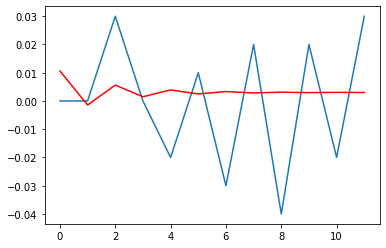

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

**16. По ряду ошибок постройте корреляционную и частную автокорреляционную функцию. Воспользуйтесь соответственно функциями plot_acf() и plot_pacf() из модуля statsmodels.graphics.tsaplots и функцией show() из модуля matplotlib.pyplot. Сделайте предположение о q - порядке скользящего среднего в модели ARIMA.**

In [ ]:
err=model_fit.resid
err

array([-0.01234396,  0.00106846, -0.02478465, -0.01649086,  0.02521535,
       -0.01722533, -0.00234396, -0.00307843, -0.03063775, -0.00649086,
       -0.01893154,  0.02350914, -0.01137222,  0.00765604, -0.01722533,
        0.01765604,  0.02862778,  0.01106846,  0.01106846, -0.02893154,
       -0.01234396,  0.03106846,  0.01277467,  0.01521535,  0.01692157,
       -0.02893154,  0.01765604, -0.03137222, -0.00405017,  0.02277467,
        0.01106846,  0.02106846,  0.00692157, -0.01478465])

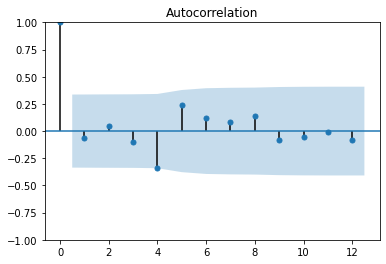

In [ ]:
plot_acf(err,lags=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


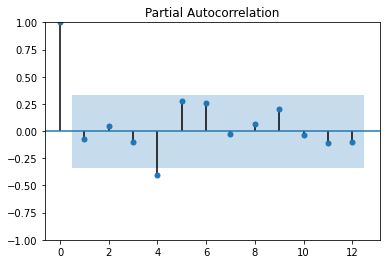

In [ ]:
plot_pacf(err,lags=12)
plt.show()

# **q=4?**

**17. Воспользуйтесь функцией ar_select_order() из модуля statsmodels.tsa.ar_model, чтобы определить оптимальный по критерию BIC порядок q для ряда ошибок. Прокомментируйте результат.**

In [ ]:
modelq=ar_select_order(err, maxlag=max_tau,old_names=False)

In [ ]:
fg = modelq.ar_lags

In [ ]:
fg

# **q=0 (он говорит)**

# **p, d, q = 1, 1, 0 (4)**

**19. Оцените коэффициенты одной из моделей, воспользовавшись функцией ARIMA() из модуля statsmodels.tsa.arima_model. Обучите ее с помощью функции fit(). Выведите на экран описательные статистики по обученной модели с помощью функции summary(). Посмотрите на ошибки модели, обратившись к параметру resid. Постройте для них линейный график и функцию плотности распределения, воспользовавшись функциями plot() и show() из модуля matplotlib.pyplot. Выведите для ошибок описательные статистики, воспользовавшись функцией describe(). Прокомментируйте результат.**

In [ ]:
model=ARIMA(series, order=(1,1,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
model_fit=model.fit()

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   48
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 119.761
Date:                Sat, 10 Sep 2022   AIC                           -235.523
Time:                        06:54:09   BIC                           -231.822
Sample:                    01-01-2007   HQIC                          -234.130
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5944      0.132     -4.513      0.000      -0.853      -0.336
sigma2         0.0004      0.000      3.161      0.002       0.000       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [ ]:
residuals=pd.DataFrame(model_fit.resid) # вытаскиваем ошибки

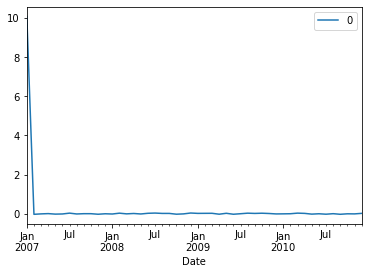

In [ ]:
residuals.plot()
plt.show()

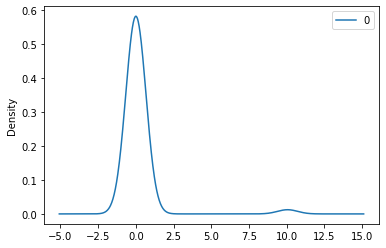

In [ ]:
residuals.plot(kind='kde') # график распределения ошибок
plt.show()

In [ ]:
residuals.describe()

,0
count,48.000000
mean,0.212077
std,1.453265
min,-0.030000
25%,-0.011958
50%,0.001084
75%,0.018584
max,10.070000


**20. Проведите поиск по сетке (Grid Search) оптимальных с точки зрения критерия RMSE параметров p, d, q модели ARIMA. Выведите на экран лучший результат.**

In [ ]:
# grid search ARIMA parameters for time series
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 4, 5]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3, 4]
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


In [ ]:
model=ARIMA(series, order=(1,1,4))

In [ ]:
model_fit=model.fit()

In [ ]:
print(model_fit.summary()) #  чем больше  Log Likelihood, тем лучше
# P>|z|(хначимы ли коэффициенты), если меньше 0.05, то значимы, это хорошо

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   48
Model:                 ARIMA(1, 1, 4)   Log Likelihood                 123.348
Date:                Sat, 10 Sep 2022   AIC                           -234.696
Time:                        06:55:51   BIC                           -223.595
Sample:                    01-01-2007   HQIC                          -230.518
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6193      0.348      1.781      0.075      -0.062       1.301
ma.L1         -1.2607      0.294     -4.290      0.000      -1.837      -0.685
ma.L2          0.9621      0.258      3.733      0.0

In [ ]:
residuals=pd.DataFrame(model_fit.resid)

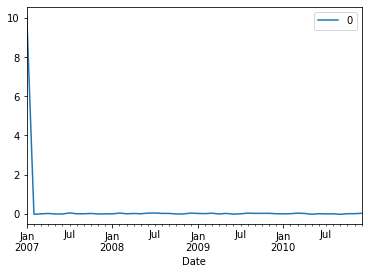

In [ ]:
residuals.plot()
plt.show()

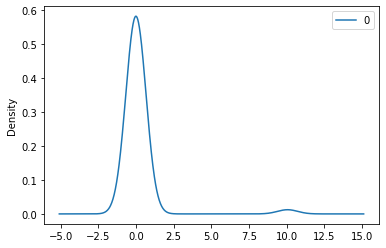

In [ ]:
residuals.plot(kind='kde')
plt.show()

In [ ]:
residuals.describe()

,0
count,48.000000
mean,0.210759
std,1.453444
min,-0.034366
25%,-0.010378
50%,-0.002093
75%,0.015341
max,10.070000


In [ ]:
model_fit.forecast(12)

2011-01-01    10.128888
2011-02-01    10.133517
2011-03-01    10.120320
2011-04-01    10.121392
2011-05-01    10.122056
2011-06-01    10.122467
2011-07-01    10.122721
2011-08-01    10.122879
2011-09-01    10.122976
2011-10-01    10.123037
2011-11-01    10.123074
2011-12-01    10.123097
Freq: MS, Name: predicted_mean, dtype: float64

# **Прогноз на следующий год:**

In [ ]:
model_fit.forecast(12)

2011-01-01    10.128888
2011-02-01    10.133517
2011-03-01    10.120320
2011-04-01    10.121392
2011-05-01    10.122056
2011-06-01    10.122467
2011-07-01    10.122721
2011-08-01    10.122879
2011-09-01    10.122976
2011-10-01    10.123037
2011-11-01    10.123074
2011-12-01    10.123097
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
# Определите p, d и q в диапазоне 0-2
p = d = q = range(0, 4)
# Сгенерируйте различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируйте комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# Задание 9

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
import scipy
from scipy.optimize import differential_evolution, minimize

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab_data/data_TS/')

FileNotFoundError: ignored

In [ ]:
data=pd.read_excel('data.xls', sheet_name='Income')
data.head()

In [ ]:
dates =data.loc[data.index==0].values[0,2:]
val =data.loc[data.index==1].values[0,2:]

In [ ]:
data={'Date':dates,'Value':val}

In [ ]:
df=pd.DataFrame(data)
df.head()

In [ ]:
df=df.set_index('Date')
df.head()

In [ ]:
df.info()

In [ ]:
df.Value = df.Value.astype(float)

In [ ]:
df.info()

In [ ]:
alpha=0.99

In [ ]:
df['t']=np.array([i for i in range(1,len(df)+1)])

In [ ]:
df['v']=np.array([alpha*(1-alpha)**(len(df)-i) for i in range(1,len(df)+1)])

In [ ]:
b=(np.sum(df['t']*df['v']*df['Value'])-np.sum(df['t']*df['v'])*np.sum(df['Value']*df['v']))/(np.sum(np.power(df['t'],2)*df['v'])-np.power(np.sum(df['t']*df['v']),2))

In [ ]:
a=np.sum(df['Value']*df['v'])-b*np.sum(df['t']*df['v'])

In [ ]:
print(a,b)

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Value'], label = 'Доходы населения')
ax.plot(a + b * pd.Series(np.array([i for i in range(1, len(df) + 13)]), pd.date_range(start='2007-01', end='2011-12', freq = 'MS')), label = 'МНК с дисконтированием', linestyle = '--')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели МНК с дисконтированием')

plt.show()

In [ ]:
span=10

In [ ]:
alfa=2/(span+1)
alfa

In [ ]:
ema=df['Value'].ewm(span=span).mean()
ema.head()

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Value'], label = 'Доходы населения')
ax.plot(a + b * pd.Series(np.array([i for i in range(1, len(df) + 13)]), pd.date_range(start='2007-01', end='2011-12', freq = 'MS')), label = 'МНК с дисконтированием', linestyle = '--')
ax.plot(ema,label='Модель Брауна (модель экспоненциального сглаживания)')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели МНК с дисконтированием и модели Брауна')

plt.show()

In [ ]:
span=3

In [ ]:
alfa=2/(span+1)
alfa

In [ ]:
ema=df['Value'].ewm(span=span).mean()
ema.head()

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Value'], label = 'Доходы населения')
ax.plot(a + b * pd.Series(np.array([i for i in range(1, len(df) + 13)]), pd.date_range(start='2007-01', end='2011-12', freq = 'MS')), label = 'МНК с дисконтированием', linestyle = '--')
ax.plot(ema,label='Модель Брауна (модель экспоненциального сглаживания)')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели МНК с дисконтированием и модели Брауна')

plt.show()

In [ ]:
model=SimpleExpSmoothing(df['Value'], initialization_method='estimated').fit()

In [ ]:
model.params_formatted

In [ ]:
y_pred=model.fittedvalues
y_pred.head()

In [ ]:
y=df['Value']
y.head()

In [ ]:
MSE=mean_squared_error(y, y_pred)
MSE

In [ ]:
RMSE=sqrt(MSE)
RMSE

In [ ]:
model.predict(start=48, end=59)

In [ ]:
model.forecast(12)

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Value'], label = 'Доходы населения')
ax.plot(a + b * pd.Series(np.array([i for i in range(1, len(df) + 13)]), pd.date_range(start='2007-01', end='2011-12', freq = 'MS')), label = 'МНК с дисконтированием', linestyle = '--')
ax.plot(ema,label='Модель Брауна (модель экспоненциального сглаживания)')
ax.plot(model.predict(start=48, end=59), label='Прогноз по модели Брауна')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели МНК с дисконтированием и модели Брауна')

plt.show()

In [ ]:
model=Holt(df['Value'], initialization_method="estimated").fit()

In [ ]:
y_pred=model.fittedvalues
y_pred.head()

In [ ]:
y=df['Value']
y.head()

In [ ]:
MSE=mean_squared_error(y, y_pred)
MSE

In [ ]:
RMSE=sqrt(MSE)
RMSE

In [ ]:
model.predict(start=48, end=59)

In [ ]:
y_new=model.forecast(12)
y_new

In [ ]:
np.save('income_new.npy',model.forecast(12))

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Value'], label = 'Доходы населения')
ax.plot(y_pred, label = 'Модель Хольта')
ax.plot(model.forecast(12), label = 'Прогноз по модели Хольта')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели Хольта')

plt.show()

In [ ]:
sigma=scipy.stats.sem(y)
sigma

In [ ]:
conf=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1+conf)/2.,len(y)-1)
tstu

In [ ]:
y_up=y_new+tstu*sigma
y_up

In [ ]:
np.save('income_up.npy',y_up)

In [ ]:
y_down=y_new-tstu*sigma
y_down

In [ ]:
np.save('income_down.npy',y_down)

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(df['Value'], label = 'Доходы населения')
ax.plot(y_pred, label = 'Модель Хольта')
ax.plot(model.forecast(12), label = 'Прогноз по модели Хольта')
ax.plot(y_up, label = 'Верхняя граница прогнозного интервала')
ax.plot(y_down, label = 'Нижняя граница прогнозного интервала')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели Хольта')

plt.show()